# Scenario modelling

This notebook illustrates how to model indicators based on a pre-defined scenario.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import demoland_engine

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_89741/329694679.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


## Output area level

The scenario is defined via four variables (signature type, use, green space, job types) for every output area. You can start from the `empty.parquet` that contains the structure and is filled with `None`. When values for a single OA are all `None`, we do not alter any underlying value and use what is currently observed. When we specify a value for use, green space or job types, the algorithm updates the existing observed values accordingly. When we change a signature type to a different type than is currently observed, we sample the values from the country-wide distribution. The changes of se, green space or job types in such a case adapt these sampled values.

In [2]:
df = demoland_engine.get_empty()
df.head()

,signature_type,use,greenspace,job_types
geo_code,,,,
E00042786,None,None,None,None
E00042707,None,None,None,None
E00042703,None,None,None,None
E00042782,None,None,None,None
E00042789,None,None,None,None


When all values are `None`, the `get_indicators` function retrieves the baseline data reflecting the current state and predicts on that.

See the docstring of `get_indicators` to understand how what the values in individual columns mean.

In [3]:
help(demoland_engine.get_indicators)

Help on function get_indicators in module demoland_engine.predictors:

get_indicators(df)
    Get indicators for all OAs based on 4 variables
    
    Parameters
    ----------
    df : DataFrame
        DataFrame reflecting the intended change of each OA.
    
        See the usage.ipynb for an example.
    
        The bounds of allowed values per column:
    
            signature_type : int
                Int representing signature type. See below the possible options
                and their relationship to the signature type.
    
                    0: 'Wild countryside',
                    1: 'Countryside agriculture',
                    2: 'Urban buffer',
                    3: 'Warehouse/Park land',
                    4: 'Open sprawl',
                    5: 'Disconnected suburbia',
                    6: 'Accessible suburbia',
                    7: 'Connected residential neighbourhoods',
                    8: 'Dense residential neighbourhoods',
                    9: 

With a DataFrame set to all None, we can retrieve a baseline prediction.

In [4]:
%%time
default = demoland_engine.get_indicators(df)

CPU times: user 2.83 s, sys: 341 ms, total: 3.17 s
Wall time: 3.11 s


In [5]:
default.head()

,air_quality,house_price,job_accessibility,greenspace_accessibility
geo_code,,,,
E00042786,15.499825,7.318359,2313.0,273920.09500
E00042707,14.388634,8.107953,12862.0,298640.16545
E00042703,13.898852,7.561330,1548.0,505787.49050
E00042782,13.143233,7.345436,3310.0,253491.99240
E00042789,15.600549,7.296721,2267.0,219076.32555


When you change the information, either the adaptation of existing values (like in case of `greenspace` or `job_types`) or drawing of new values from a known distribution happens.

In [6]:
df.loc[df.sample(500).index, "greenspace"] = 0.5

Then we get indicators based on a specified scenario.

In [7]:
%%time
changed = demoland_engine.get_indicators(df)

CPU times: user 2.64 s, sys: 328 ms, total: 2.96 s
Wall time: 2.88 s


You can plot the two results.

In [8]:
data_folder = "/Users/martin/Library/CloudStorage/OneDrive-SharedLibraries-TheAlanTuringInstitute/Daniel Arribas-Bel - demoland_data"
geom = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet")

<AxesSubplot: >

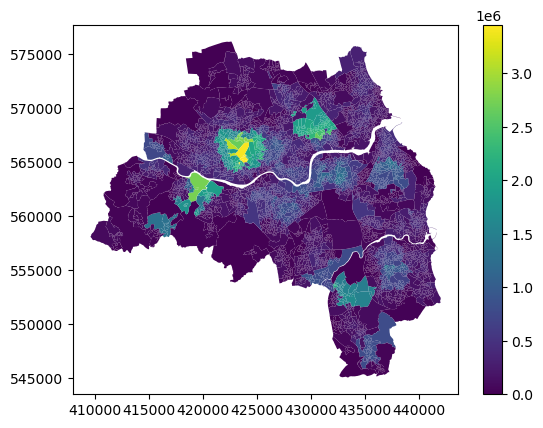

In [9]:
geom.plot(default.greenspace_accessibility.values, legend=True)

<AxesSubplot: >

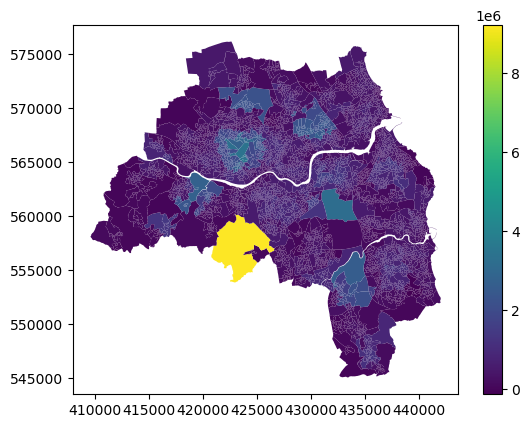

In [10]:
geom.plot(changed.greenspace_accessibility.values, legend=True)

And then check the difference between the two.

<AxesSubplot: >

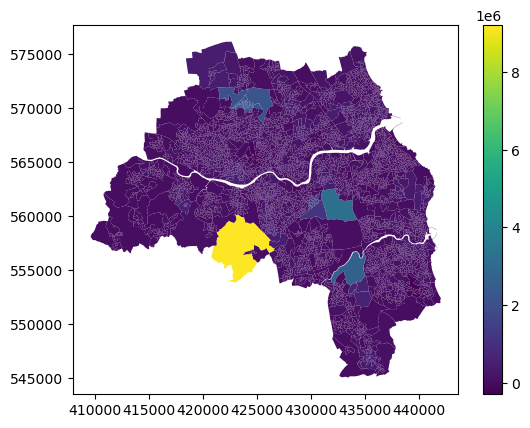

In [11]:
geom.plot(
    changed.greenspace_accessibility.values - default.greenspace_accessibility.values,
    legend=True,
)

The same applies to all indicators. Note that it can take a some time (10-20s) to sample values if you change many OAs.

## LSOA level

The same works on the LSOA level. The function joins the LSOA level data to OA, processes the sampling and prediction on the OA level and aggregates indicator data back to LSOA.

In [12]:
lsoa_input = demoland_engine.get_empty_lsoa()
lsoa_input.head()

,signature_type,use,greenspace,job_types
E01008162,None,None,None,None
E01008163,None,None,None,None
E01008164,None,None,None,None
E01008165,None,None,None,None
E01008166,None,None,None,None


If you want to redefine every LSOA (and every OA), you can specify a signature type for each. You can further specify any other input variable.

In [13]:
lsoa_input["signature_type"] = np.random.randint(0, 16, len(lsoa_input))
lsoa_input["use"] = np.random.uniform(-1, 1, len(lsoa_input))
lsoa_input["greenspace"] = np.random.uniform(0, 1, len(lsoa_input))
lsoa_input["job_types"] = np.random.uniform(0, 1, len(lsoa_input))

In [14]:
lsoa_input.head()

,signature_type,use,greenspace,job_types
E01008162,4,0.520502,0.969242,0.490257
E01008163,15,0.851493,0.426005,0.725856
E01008164,14,0.461305,0.876282,0.002806
E01008165,1,0.846866,0.509362,0.717493
E01008166,6,0.517322,0.506808,0.989327


In [15]:
%%time
lsoa_indicators = demoland_engine.get_indicators_lsoa(lsoa_input)

CPU times: user 11 s, sys: 405 ms, total: 11.4 s
Wall time: 11.3 s


As mentioned above, this takes some time as we are sampling more than 220k values. For an iterative process, it may be needed a slight refactor to ensure only the changed OAs or LSOAs are sampled and the rest remains.